### SELF-SUPERVISED SEISMIC DENOISING: PART FOUR 
# Coherent Noise Suppression with Blind-Trace Networks: Field Data Application
### _Authors: [Claire Birnie](https://cebirnie92.github.io/)_ _and_ _[Sixiu Liu](https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))_ , _KAUST_

-------------------

This is the fourth tutorial in our self-supervised seismic denoising tutorial series where we apply our blind-trace noise suppression method to a field dataset. 

The tutorial notebooks were originally designed to supplement the course slides. However, it should still be easy to follow provided you have read the reference paper and understood the key concepts.

## Tutorial Objectives
On completion of this tutorial, you will have 
- loaded a seismic-while-drilling dataset with strong trace-wise noise
- use helper functions to cut the data into training patches
- use your function from tutorial 3 to select active pixels and corrupt their full trace values
- use helper functions to load a UNet
- import your previously written train and evaluate functions
- write the training procedure
- apply the trained network to the original noisy data

## Prior Requisites:
This tutorial relies on the training and evaluate functions from tutorial 1, and the corruption function from tutorial 3. These have been copied into ssdn_functions.py. If you have not completed the earlier tutorials, it is advised to do so, such that you can get a full understanding of the workflow. 


## Reference Paper:
Liu, S., Birnie, C. and Alkhalifah, T., 2023. Trace-wise coherent noise suppression via a self-supervised blind-trace deep-learning scheme. Geophysics, 88(6), pp.V459-V472.

[[Paper Link]](https://doi.org/10.1190/geo2022-0371.1)

## Key Concepts Recap
#### _N2V: Random Noise Suppression_
In this series of tutorials, we implement the Noise2Void methodology of [Krull et al., [2019]](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) for self-supervised denoising using blind-spot networks. This approach involves a pre-processing step that identifies a set of 'active' pixels, substituting their original noisy values with those of neighboring pixels. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations. Assuming the noise is i.i.d., the network is unable to predict the noise component of the active pixels' original values, thereby learning to reconstruct only the signal component. This results in a denoised image.

#### _StructN2V: Coherent Noise Suppression_
N2V requires noise to be independent, however this is a rare occurrence. [Broaddus et al., [2020]](https://ieeexplore.ieee.org/document/9098336) proposed StructN2V to extend the blind-spot methodology to coherent noise suppression. To do so, first, the raw data is evaluated to determine the relationship between noise elements across pixels. This analysis is used to build a noise mask that is designed to hide any pixels which exhibit coherency between their noise elements and the noise of the central pixel. Once the mask is designed, active pixels are selected (like in the original N2V methodology) however now not only is the central pixel's value changed, as is all pixels that fall within the noise mask. As the mask covers neighbouring pixels, the  values used for corruption are typically drawn from a predefined distribution.  Corrupting all pixels within the mask region ensures the input to the network has no useable information for predicting the noise component of the central pixels. As before, the loss is only computed at the active pixels locations. In theory, the network learns to use pixels out with the masked area to recreate the central pixel's value.


***

In [1]:
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
import tutorial_utils as tu
import plotting_utils as pu


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='RdBu'
vmin = -0.25
vmax = 0.25

# For reproducibility purposes we set random, numpy and torch seeds
tu.set_seed(42) 

# Set paths
data_dir = './data'
networks_dir = './trained_networks'

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access. 

In this instance I have downloaded the file and added to a folder in this repository title 'data'.

In [3]:
d = np.load(os.path.join(data_dir,"Stryde_SWD.npz"))['data']

# Check data dimensions
print(d.shape)

(7200240, 89)


In [4]:
field_data = 10*d[6250:6250+2048,:84]/np.max(abs(d[6250:6250+2048,:84]))


#### Plot the data to see what it looks like

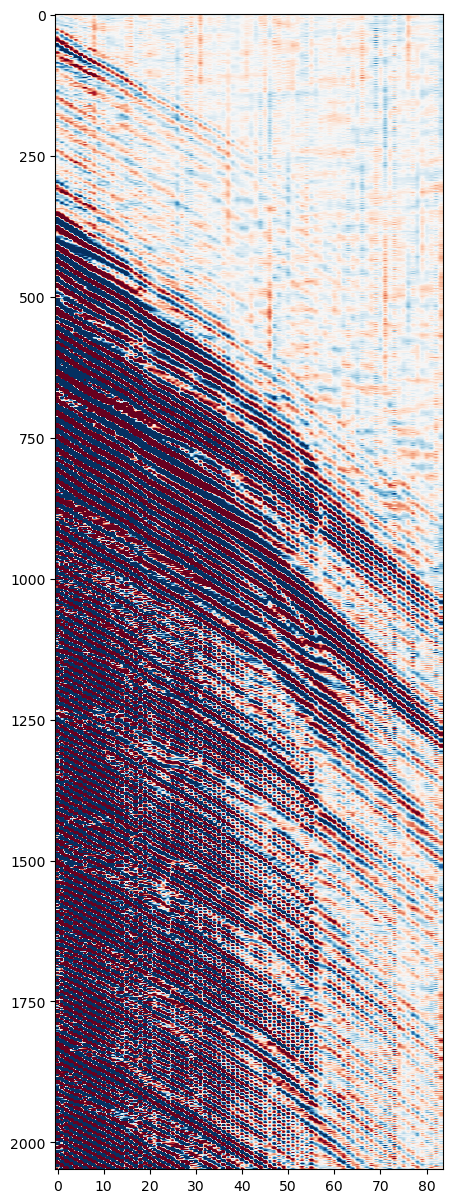

In [5]:
plt.figure(figsize=[5,15])
plt.imshow(field_data, 
           cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

### Patch data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [6]:
# Regularly extract patches from the noisy data
noisy_patches = tu.regular_patching_2D(field_data, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 4536 patches


#### Visualise the training patches

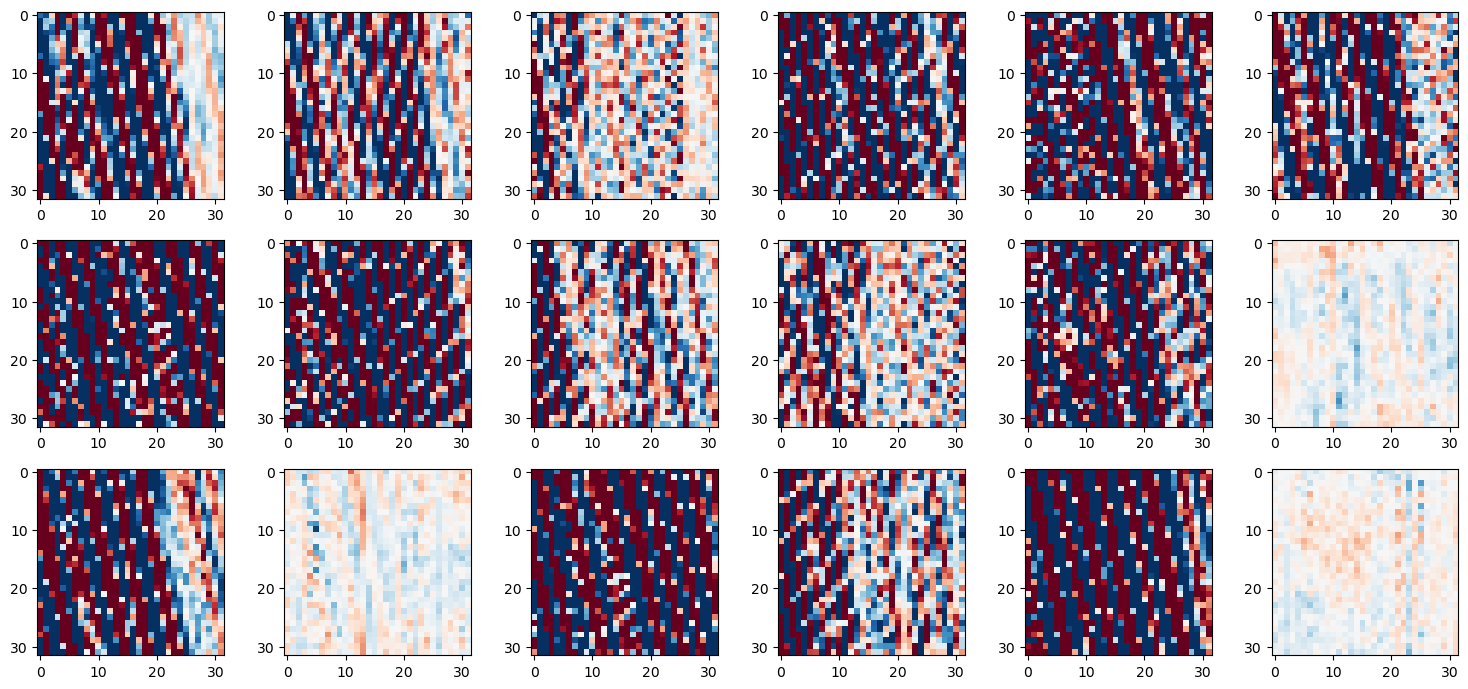

In [7]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:

    - selecting the active pixels 
    - selecting the neighbourhood pixel for each active pixel, which it will take the value of
    - replacing each active pixels' value with its neighbourhood pixels' value
    - creating a active pixel 'mask' which shows the location of the active pixels on the patch
    
The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

#### To do: Create a function that randomly selects and corrupts pixels following N2V methodology

In [8]:
def blind_trace_corruption(patch, 
                           num_activepixels, 
                           noise_level=0.5,
                          ):
    """ Function to identify multiple active pixels and replace with values from a random distribution

    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    num_activepixels : int
        Number of active pixels to be selected within the patch
    NoiseLevel : float
        Random values from a uniform distribution over
        [-NoiseLevel, NoiseLevel] will be used to corrupt the traces belonging to the active pixels
        to generate the corrupted data

    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch
        mask : numpy 2D array
            Mask showing location of corrupted traces within the patch
    """

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    active_traces_indices = np.random.choice(np.arange(patch.shape[1]), size=num_activepixels)
    
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP TWO: REPLACE ACTIVE PIXEL's TRACE VALUES
    cp_ptch = patch.copy()
    
    cp_ptch[:, active_traces_indices] = np.random.rand(patch.shape[0], num_activepixels) * (noise_level * 2) - noise_level

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP THREE: Make mask for calculating loss
    mask = np.ones_like(patch)
    mask[:, active_traces_indices] = 0

    return cp_ptch, mask


#### TO DO:  CHECK THE CORRUPTION FUNCTION WORKS

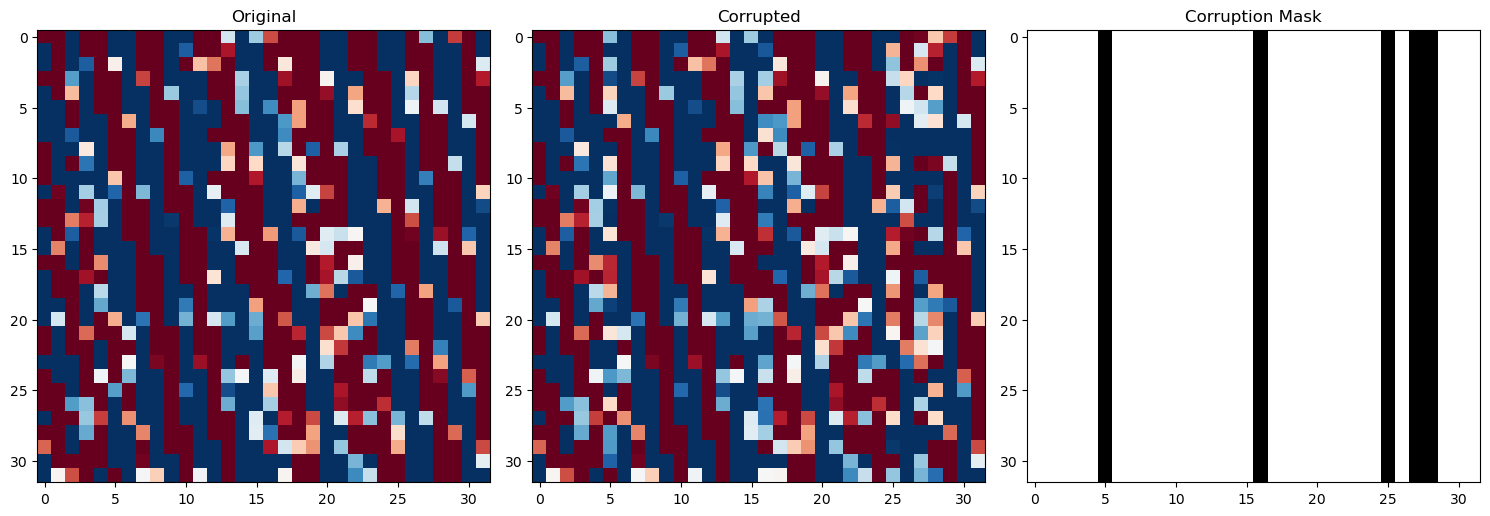

In [9]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_trace_corruption(noisy_patches[6],
                                          num_activepixels=5, 
                                          )

# Use the pre-made plotting function to visualise the corruption
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)

In the original N2V examples the authors use between 0.5 and 2% for the number of active pixels within a patch.

In Birnie et al., 2021 where they use this methodology for the suppression of white, Gaussian noise, the authors use 0.2%. However, in their example they have substantially more training patches.

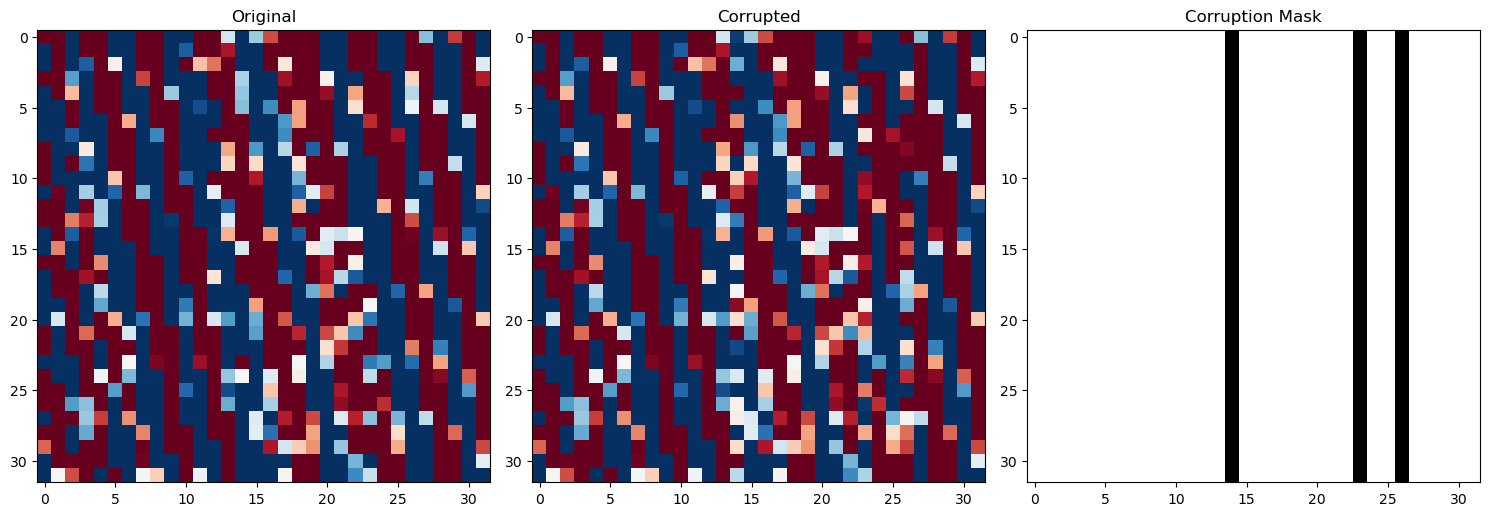

In [10]:
# Choose the number of active pixels per patch
num_activepixels = 3

# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_trace_corruption(noisy_patches[6], 
                                          num_activepixels=num_activepixels, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

***

# Step three - Set up network

In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [11]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
elif torch.backends.mps.is_available(): 
    print("M1 installed! Running on M1!")
    device = torch.device("mps")
else:
    print("No GPU available!")

M1 installed! Running on M1!


#### Build the network

In [12]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(tu.weights_init) 

#### Select the networks training parameters

In [13]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step four - Network Training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [14]:
# Choose the number of epochs
n_epochs = 100  # most recommend 150-200 for random noise suppression 

# Choose number of training and validation samples
n_training = 4096
n_test = 512

# Choose the batch size for the networks training
batch_size = 128

In [15]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

#### TO DO: INCORPORATE LOSS FUNCTION INTO TRAINING PROCEDURE

In [16]:
from ssdn_functions import n2v_train, n2v_evaluate

#### TO DO: COMPLETE TRAINING LOOP BY INCORPORATING ABOVE FUNCTIONS

In [17]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = blind_trace_corruption(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = tu.make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')

torch.save(network, os.path.join(networks_dir,'Tutorial4_FieldBlindtrace.net'))

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch 0, 
    Training Loss 0.0295,     Training Accuracy 0.5664, 
    Test Loss 0.0191,     Test Accuracy 0.4926 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.70it/s]


Epoch 1, 
    Training Loss 0.0161,     Training Accuracy 0.4565, 
    Test Loss 0.0184,     Test Accuracy 0.4532 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.60it/s]


Epoch 2, 
    Training Loss 0.0135,     Training Accuracy 0.4117, 
    Test Loss 0.0129,     Test Accuracy 0.4117 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.08it/s]


Epoch 3, 
    Training Loss 0.0122,     Training Accuracy 0.3919, 
    Test Loss 0.0114,     Test Accuracy 0.4017 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


Epoch 4, 
    Training Loss 0.0113,     Training Accuracy 0.3801, 
    Test Loss 0.0156,     Test Accuracy 0.4046 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.90it/s]


Epoch 5, 
    Training Loss 0.0104,     Training Accuracy 0.3753, 
    Test Loss 0.0101,     Test Accuracy 0.3923 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.23it/s]


Epoch 6, 
    Training Loss 0.0101,     Training Accuracy 0.3720, 
    Test Loss 0.0119,     Test Accuracy 0.3989 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.69it/s]


Epoch 7, 
    Training Loss 0.0092,     Training Accuracy 0.3689, 
    Test Loss 0.0105,     Test Accuracy 0.3844 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.91it/s]


Epoch 8, 
    Training Loss 0.0088,     Training Accuracy 0.3628, 
    Test Loss 0.0096,     Test Accuracy 0.3796 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.20it/s]


Epoch 9, 
    Training Loss 0.0092,     Training Accuracy 0.3606, 
    Test Loss 0.0102,     Test Accuracy 0.3826 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.37it/s]


Epoch 10, 
    Training Loss 0.0097,     Training Accuracy 0.3646, 
    Test Loss 0.0085,     Test Accuracy 0.3815 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.54it/s]


Epoch 11, 
    Training Loss 0.0092,     Training Accuracy 0.3573, 
    Test Loss 0.0102,     Test Accuracy 0.3733 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.96it/s]


Epoch 12, 
    Training Loss 0.0083,     Training Accuracy 0.3557, 
    Test Loss 0.0116,     Test Accuracy 0.3777 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.21it/s]


Epoch 13, 
    Training Loss 0.0079,     Training Accuracy 0.3516, 
    Test Loss 0.0096,     Test Accuracy 0.3747 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.40it/s]


Epoch 14, 
    Training Loss 0.0081,     Training Accuracy 0.3513, 
    Test Loss 0.0097,     Test Accuracy 0.3733 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.50it/s]


Epoch 15, 
    Training Loss 0.0080,     Training Accuracy 0.3534, 
    Test Loss 0.0081,     Test Accuracy 0.3794 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.92it/s]


Epoch 16, 
    Training Loss 0.0079,     Training Accuracy 0.3520, 
    Test Loss 0.0089,     Test Accuracy 0.3702 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.07it/s]


Epoch 17, 
    Training Loss 0.0079,     Training Accuracy 0.3512, 
    Test Loss 0.0077,     Test Accuracy 0.3742 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.59it/s]


Epoch 18, 
    Training Loss 0.0078,     Training Accuracy 0.3479, 
    Test Loss 0.0085,     Test Accuracy 0.3705 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.57it/s]


Epoch 19, 
    Training Loss 0.0078,     Training Accuracy 0.3497, 
    Test Loss 0.0075,     Test Accuracy 0.3595 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.59it/s]


Epoch 20, 
    Training Loss 0.0076,     Training Accuracy 0.3428, 
    Test Loss 0.0078,     Test Accuracy 0.3634 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.08it/s]


Epoch 21, 
    Training Loss 0.0075,     Training Accuracy 0.3457, 
    Test Loss 0.0084,     Test Accuracy 0.3626 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.79it/s]


Epoch 22, 
    Training Loss 0.0076,     Training Accuracy 0.3441, 
    Test Loss 0.0075,     Test Accuracy 0.3521 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.20it/s]


Epoch 23, 
    Training Loss 0.0069,     Training Accuracy 0.3359, 
    Test Loss 0.0079,     Test Accuracy 0.3521 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.13it/s]


Epoch 24, 
    Training Loss 0.0073,     Training Accuracy 0.3374, 
    Test Loss 0.0073,     Test Accuracy 0.3569 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.89it/s]


Epoch 25, 
    Training Loss 0.0070,     Training Accuracy 0.3362, 
    Test Loss 0.0069,     Test Accuracy 0.3555 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.52it/s]


Epoch 26, 
    Training Loss 0.0079,     Training Accuracy 0.3409, 
    Test Loss 0.0075,     Test Accuracy 0.3510 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.31it/s]


Epoch 27, 
    Training Loss 0.0069,     Training Accuracy 0.3357, 
    Test Loss 0.0072,     Test Accuracy 0.3623 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.78it/s]


Epoch 28, 
    Training Loss 0.0066,     Training Accuracy 0.3342, 
    Test Loss 0.0071,     Test Accuracy 0.3496 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.19it/s]


Epoch 29, 
    Training Loss 0.0068,     Training Accuracy 0.3321, 
    Test Loss 0.0072,     Test Accuracy 0.3546 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.90it/s]


Epoch 30, 
    Training Loss 0.0066,     Training Accuracy 0.3311, 
    Test Loss 0.0069,     Test Accuracy 0.3451 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.71it/s]


Epoch 31, 
    Training Loss 0.0069,     Training Accuracy 0.3287, 
    Test Loss 0.0077,     Test Accuracy 0.3397 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.85it/s]


Epoch 32, 
    Training Loss 0.0066,     Training Accuracy 0.3299, 
    Test Loss 0.0074,     Test Accuracy 0.3505 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.76it/s]


Epoch 33, 
    Training Loss 0.0065,     Training Accuracy 0.3306, 
    Test Loss 0.0093,     Test Accuracy 0.3570 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.44it/s]


Epoch 34, 
    Training Loss 0.0066,     Training Accuracy 0.3267, 
    Test Loss 0.0083,     Test Accuracy 0.3456 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.31it/s]


Epoch 35, 
    Training Loss 0.0066,     Training Accuracy 0.3283, 
    Test Loss 0.0067,     Test Accuracy 0.3483 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.06it/s]


Epoch 36, 
    Training Loss 0.0066,     Training Accuracy 0.3276, 
    Test Loss 0.0085,     Test Accuracy 0.3452 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.83it/s]


Epoch 37, 
    Training Loss 0.0067,     Training Accuracy 0.3255, 
    Test Loss 0.0073,     Test Accuracy 0.3505 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.20it/s]


Epoch 38, 
    Training Loss 0.0064,     Training Accuracy 0.3254, 
    Test Loss 0.0063,     Test Accuracy 0.3479 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.85it/s]


Epoch 39, 
    Training Loss 0.0063,     Training Accuracy 0.3240, 
    Test Loss 0.0066,     Test Accuracy 0.3329 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.92it/s]


Epoch 40, 
    Training Loss 0.0065,     Training Accuracy 0.3212, 
    Test Loss 0.0073,     Test Accuracy 0.3425 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.68it/s]


Epoch 41, 
    Training Loss 0.0062,     Training Accuracy 0.3229, 
    Test Loss 0.0074,     Test Accuracy 0.3379 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.53it/s]


Epoch 42, 
    Training Loss 0.0066,     Training Accuracy 0.3207, 
    Test Loss 0.0062,     Test Accuracy 0.3370 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.60it/s]


Epoch 43, 
    Training Loss 0.0061,     Training Accuracy 0.3218, 
    Test Loss 0.0068,     Test Accuracy 0.3363 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.35it/s]


Epoch 44, 
    Training Loss 0.0061,     Training Accuracy 0.3192, 
    Test Loss 0.0061,     Test Accuracy 0.3307 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.17it/s]


Epoch 45, 
    Training Loss 0.0063,     Training Accuracy 0.3190, 
    Test Loss 0.0066,     Test Accuracy 0.3309 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.13it/s]


Epoch 46, 
    Training Loss 0.0062,     Training Accuracy 0.3143, 
    Test Loss 0.0067,     Test Accuracy 0.3341 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.42it/s]


Epoch 47, 
    Training Loss 0.0058,     Training Accuracy 0.3161, 
    Test Loss 0.0066,     Test Accuracy 0.3304 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.04it/s]


Epoch 48, 
    Training Loss 0.0058,     Training Accuracy 0.3163, 
    Test Loss 0.0070,     Test Accuracy 0.3385 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.55it/s]


Epoch 49, 
    Training Loss 0.0059,     Training Accuracy 0.3141, 
    Test Loss 0.0061,     Test Accuracy 0.3354 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.41it/s]


Epoch 50, 
    Training Loss 0.0057,     Training Accuracy 0.3151, 
    Test Loss 0.0055,     Test Accuracy 0.3270 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.25it/s]


Epoch 51, 
    Training Loss 0.0059,     Training Accuracy 0.3131, 
    Test Loss 0.0071,     Test Accuracy 0.3357 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.58it/s]


Epoch 52, 
    Training Loss 0.0058,     Training Accuracy 0.3136, 
    Test Loss 0.0053,     Test Accuracy 0.3264 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.62it/s]


Epoch 53, 
    Training Loss 0.0060,     Training Accuracy 0.3179, 
    Test Loss 0.0064,     Test Accuracy 0.3391 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.63it/s]


Epoch 54, 
    Training Loss 0.0058,     Training Accuracy 0.3139, 
    Test Loss 0.0065,     Test Accuracy 0.3253 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.08it/s]


Epoch 55, 
    Training Loss 0.0061,     Training Accuracy 0.3155, 
    Test Loss 0.0060,     Test Accuracy 0.3343 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.73it/s]


Epoch 56, 
    Training Loss 0.0054,     Training Accuracy 0.3118, 
    Test Loss 0.0059,     Test Accuracy 0.3286 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.73it/s]


Epoch 57, 
    Training Loss 0.0056,     Training Accuracy 0.3107, 
    Test Loss 0.0057,     Test Accuracy 0.3285 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.34it/s]


Epoch 58, 
    Training Loss 0.0058,     Training Accuracy 0.3123, 
    Test Loss 0.0062,     Test Accuracy 0.3437 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.36it/s]


Epoch 59, 
    Training Loss 0.0059,     Training Accuracy 0.3135, 
    Test Loss 0.0064,     Test Accuracy 0.3330 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.72it/s]


Epoch 60, 
    Training Loss 0.0057,     Training Accuracy 0.3114, 
    Test Loss 0.0072,     Test Accuracy 0.3273 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 18.32it/s]


Epoch 61, 
    Training Loss 0.0055,     Training Accuracy 0.3109, 
    Test Loss 0.0058,     Test Accuracy 0.3278 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.12it/s]


Epoch 62, 
    Training Loss 0.0055,     Training Accuracy 0.3118, 
    Test Loss 0.0056,     Test Accuracy 0.3301 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.99it/s]


Epoch 63, 
    Training Loss 0.0055,     Training Accuracy 0.3098, 
    Test Loss 0.0069,     Test Accuracy 0.3309 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.75it/s]


Epoch 64, 
    Training Loss 0.0056,     Training Accuracy 0.3096, 
    Test Loss 0.0066,     Test Accuracy 0.3221 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.69it/s]


Epoch 65, 
    Training Loss 0.0054,     Training Accuracy 0.3123, 
    Test Loss 0.0059,     Test Accuracy 0.3280 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.06it/s]


Epoch 66, 
    Training Loss 0.0053,     Training Accuracy 0.3103, 
    Test Loss 0.0065,     Test Accuracy 0.3315 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.72it/s]


Epoch 67, 
    Training Loss 0.0055,     Training Accuracy 0.3097, 
    Test Loss 0.0060,     Test Accuracy 0.3303 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch 68, 
    Training Loss 0.0056,     Training Accuracy 0.3084, 
    Test Loss 0.0056,     Test Accuracy 0.3238 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.05it/s]


Epoch 69, 
    Training Loss 0.0055,     Training Accuracy 0.3099, 
    Test Loss 0.0060,     Test Accuracy 0.3209 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


Epoch 70, 
    Training Loss 0.0053,     Training Accuracy 0.3082, 
    Test Loss 0.0049,     Test Accuracy 0.3269 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.71it/s]


Epoch 71, 
    Training Loss 0.0052,     Training Accuracy 0.3072, 
    Test Loss 0.0061,     Test Accuracy 0.3218 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


Epoch 72, 
    Training Loss 0.0053,     Training Accuracy 0.3088, 
    Test Loss 0.0056,     Test Accuracy 0.3226 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]


Epoch 73, 
    Training Loss 0.0054,     Training Accuracy 0.3097, 
    Test Loss 0.0054,     Test Accuracy 0.3209 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


Epoch 74, 
    Training Loss 0.0053,     Training Accuracy 0.3070, 
    Test Loss 0.0064,     Test Accuracy 0.3290 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


Epoch 75, 
    Training Loss 0.0051,     Training Accuracy 0.3109, 
    Test Loss 0.0059,     Test Accuracy 0.3349 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch 76, 
    Training Loss 0.0052,     Training Accuracy 0.3105, 
    Test Loss 0.0051,     Test Accuracy 0.3185 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


Epoch 77, 
    Training Loss 0.0051,     Training Accuracy 0.3043, 
    Test Loss 0.0056,     Test Accuracy 0.3167 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.13it/s]


Epoch 78, 
    Training Loss 0.0051,     Training Accuracy 0.3043, 
    Test Loss 0.0050,     Test Accuracy 0.3207 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


Epoch 79, 
    Training Loss 0.0050,     Training Accuracy 0.3057, 
    Test Loss 0.0060,     Test Accuracy 0.3207 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


Epoch 80, 
    Training Loss 0.0052,     Training Accuracy 0.3074, 
    Test Loss 0.0058,     Test Accuracy 0.3349 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57it/s]


Epoch 81, 
    Training Loss 0.0050,     Training Accuracy 0.3060, 
    Test Loss 0.0056,     Test Accuracy 0.3310 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Epoch 82, 
    Training Loss 0.0050,     Training Accuracy 0.3070, 
    Test Loss 0.0059,     Test Accuracy 0.3288 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch 83, 
    Training Loss 0.0050,     Training Accuracy 0.3052, 
    Test Loss 0.0056,     Test Accuracy 0.3133 


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.53it/s]


Epoch 84, 
    Training Loss 0.0048,     Training Accuracy 0.3064, 
    Test Loss 0.0060,     Test Accuracy 0.3275 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.54it/s]


Epoch 85, 
    Training Loss 0.0048,     Training Accuracy 0.3041, 
    Test Loss 0.0056,     Test Accuracy 0.3251 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Epoch 86, 
    Training Loss 0.0048,     Training Accuracy 0.3047, 
    Test Loss 0.0047,     Test Accuracy 0.3192 


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch 87, 
    Training Loss 0.0050,     Training Accuracy 0.3080, 
    Test Loss 0.0049,     Test Accuracy 0.3168 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


Epoch 88, 
    Training Loss 0.0049,     Training Accuracy 0.3040, 
    Test Loss 0.0055,     Test Accuracy 0.3296 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Epoch 89, 
    Training Loss 0.0049,     Training Accuracy 0.3080, 
    Test Loss 0.0055,     Test Accuracy 0.3369 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


Epoch 90, 
    Training Loss 0.0047,     Training Accuracy 0.3055, 
    Test Loss 0.0054,     Test Accuracy 0.3266 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch 91, 
    Training Loss 0.0047,     Training Accuracy 0.3052, 
    Test Loss 0.0054,     Test Accuracy 0.3282 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch 92, 
    Training Loss 0.0047,     Training Accuracy 0.3065, 
    Test Loss 0.0054,     Test Accuracy 0.3229 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch 93, 
    Training Loss 0.0047,     Training Accuracy 0.3045, 
    Test Loss 0.0050,     Test Accuracy 0.3233 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.10it/s]


Epoch 94, 
    Training Loss 0.0050,     Training Accuracy 0.3066, 
    Test Loss 0.0045,     Test Accuracy 0.3247 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.76it/s]


Epoch 95, 
    Training Loss 0.0048,     Training Accuracy 0.3049, 
    Test Loss 0.0053,     Test Accuracy 0.3291 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Epoch 96, 
    Training Loss 0.0047,     Training Accuracy 0.3017, 
    Test Loss 0.0054,     Test Accuracy 0.3234 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.09it/s]


Epoch 97, 
    Training Loss 0.0047,     Training Accuracy 0.3021, 
    Test Loss 0.0050,     Test Accuracy 0.3167 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.50it/s]


Epoch 98, 
    Training Loss 0.0047,     Training Accuracy 0.3031, 
    Test Loss 0.0055,     Test Accuracy 0.3208 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.73it/s]


Epoch 99, 
    Training Loss 0.0046,     Training Accuracy 0.3030, 
    Test Loss 0.0054,     Test Accuracy 0.3167 


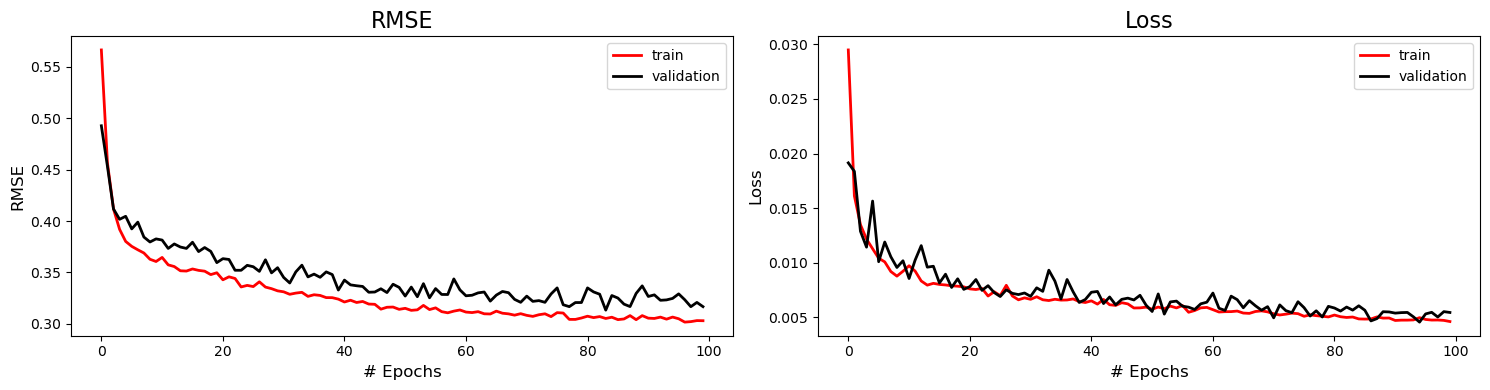

In [18]:
# Plotting trainnig metrics using pre-made function
fig,axs = pu.plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

#### TO DO: DENOISE NEW NOISY DATASET

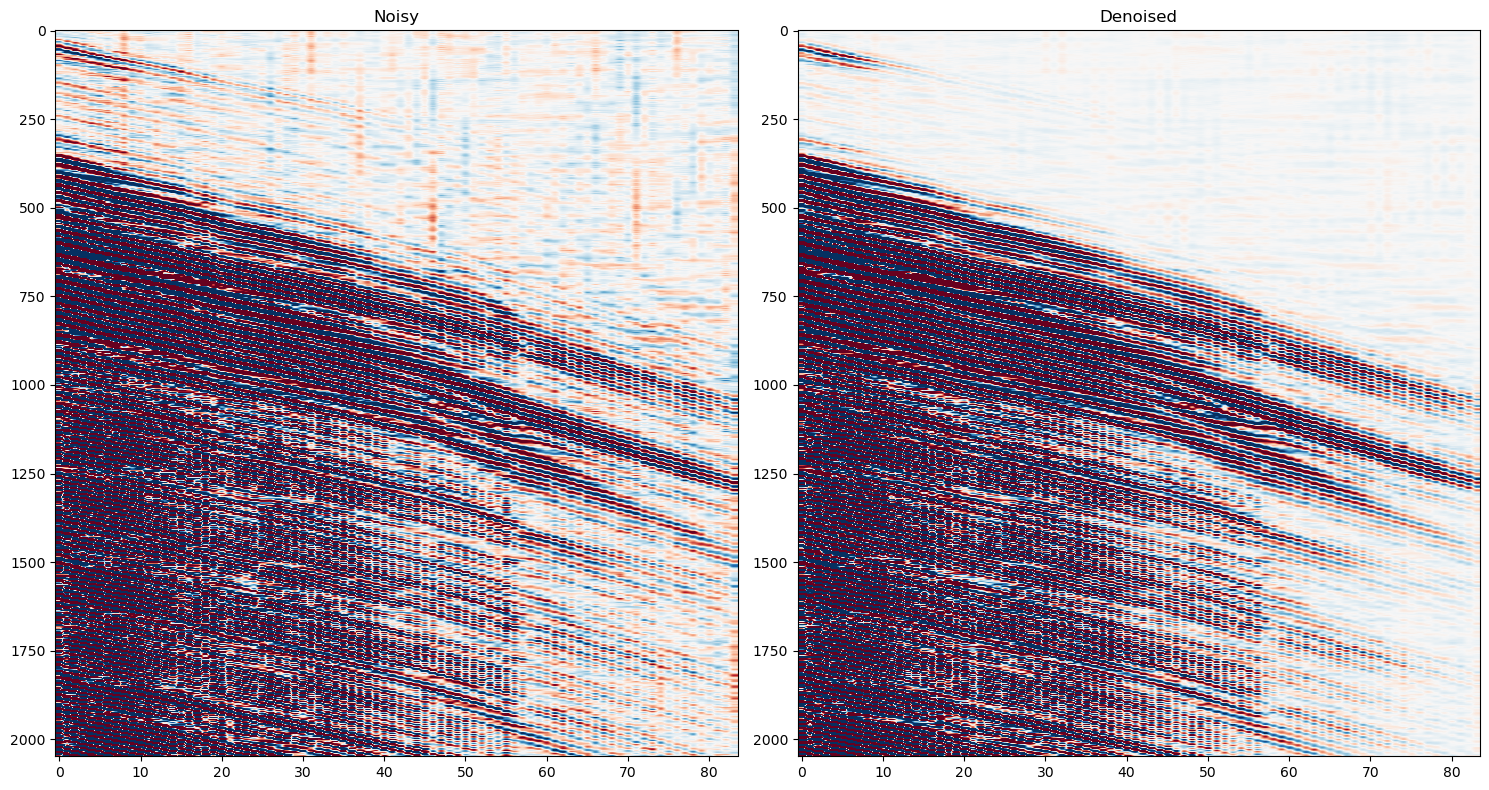

In [19]:
# Convert field dataset to tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(field_data,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = pu.plot_field_results(field_data, test_pred)